In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns

# **Single Variable Regression**

HMNS VS Features

In [2]:

df = pd.read_csv("gorilla_tug_of_war.csv")
df

,WHT,FRC,AGE,DSI,SUS,GND,HMNS
0,199.4,145,40,603,Western Lowland,Male,224
1,197.7,146,22,268,Western Lowland,Male,220
2,136.0,117,30,47,Western Lowland,Female,144
3,138.0,100,36,52,Western Lowland,Female,174
4,196.2,102,35,488,Mountain,Male,216
...,...,...,...,...,...,...,...
495,204.2,87,9,73,Cross River,Male,211
496,169.2,128,21,398,Western Lowland,Male,203
497,232.3,152,16,99,Mountain,Male,229
498,186.5,74,24,11,Mountain,Male,226


In [3]:
df.describe()

,WHT,FRC,AGE,DSI,HMNS
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,178.423200,112.752000,24.446000,211.622000,202.372000
std,43.545844,28.490242,9.391458,196.069706,29.509715
min,93.900000,37.000000,-4.000000,1.000000,88.000000
25%,150.800000,94.000000,16.000000,74.750000,188.750000
50%,175.050000,112.000000,25.000000,151.500000,212.000000
75%,202.625000,131.250000,32.000000,285.500000,223.000000
max,765.900000,203.000000,40.000000,1095.000000,249.000000


In [4]:
print("Cheking for missing values in any column")
df.isna().sum()

Cheking for missing values in any column


WHT     0
FRC     0
AGE     0
DSI     0
SUS     0
GND     0
HMNS    0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WHT     500 non-null    float64
 1   FRC     500 non-null    int64  
 2   AGE     500 non-null    int64  
 3   DSI     500 non-null    int64  
 4   SUS     500 non-null    object 
 5   GND     500 non-null    object 
 6   HMNS    500 non-null    int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 27.5+ KB


The minimum age was Negative 4 so we will delete all rows with an age that is
less than 0

The foream column is also trimmed to be less than 150 which is the most realistic for gorrilas (this is because we assume the mearsurements are in cm)


In [6]:
# drop rows where age less than 0
df = df[df["AGE"] >= 0]

#drop rows with forearm circumference greater than 150
df = df[(df["FRC"] <= 150) ]


df.describe()


,WHT,FRC,AGE,DSI,HMNS
count,451.000000,451.000000,451.000000,451.000000,451.000000
mean,174.238581,107.270510,24.662971,210.239468,200.875831
std,42.862147,23.711928,9.259802,194.209372,30.318203
min,93.900000,37.000000,8.000000,1.000000,88.000000
25%,148.450000,93.000000,17.000000,75.000000,186.000000
50%,170.300000,109.000000,26.000000,151.000000,211.000000
75%,196.550000,123.000000,32.000000,284.500000,222.000000
max,765.900000,150.000000,40.000000,1095.000000,249.000000


In [7]:
df.head()

,WHT,FRC,AGE,DSI,SUS,GND,HMNS
0,199.4,145,40,603,Western Lowland,Male,224
1,197.7,146,22,268,Western Lowland,Male,220
2,136.0,117,30,47,Western Lowland,Female,144
3,138.0,100,36,52,Western Lowland,Female,174
4,196.2,102,35,488,Mountain,Male,216


Data visualisation

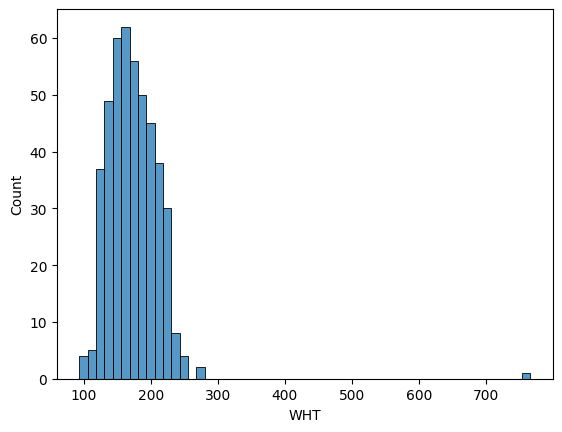

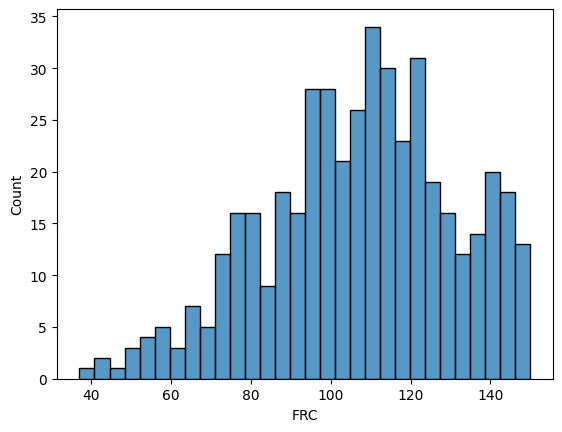

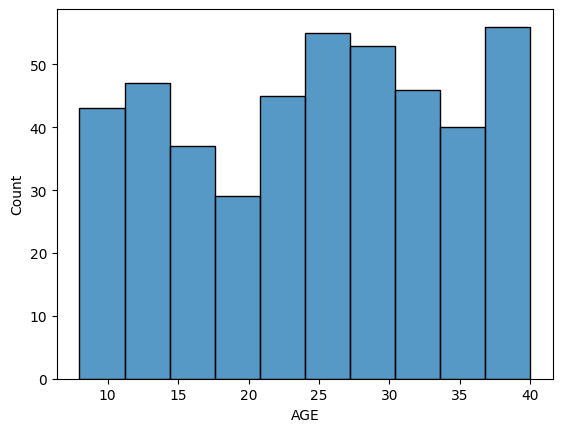

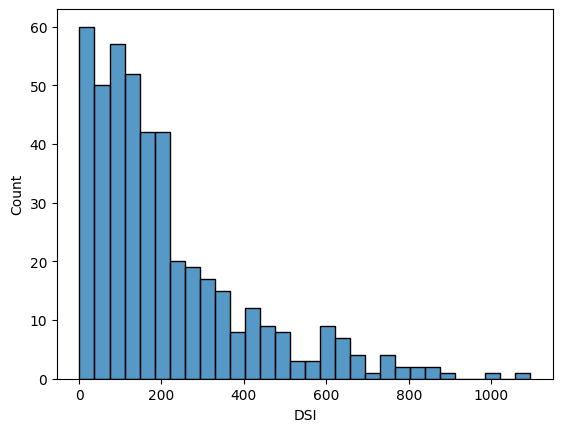

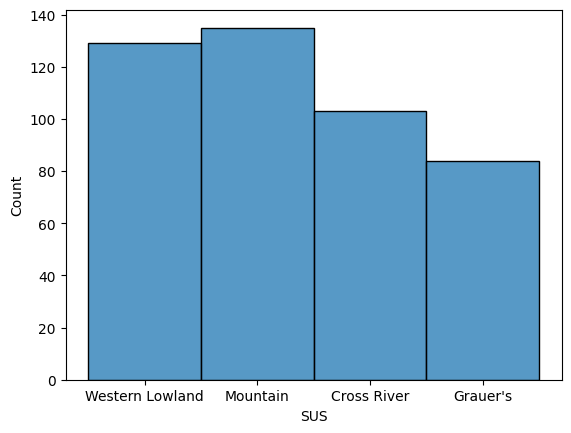

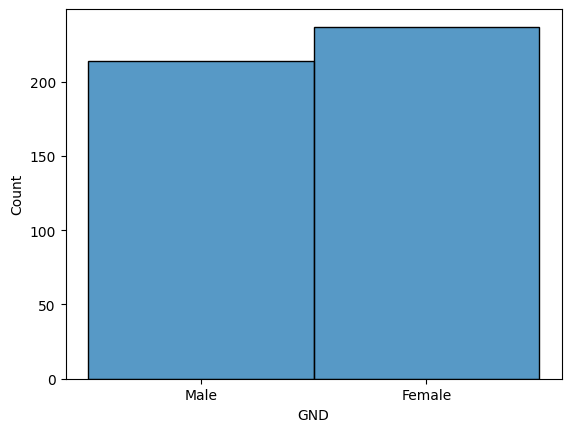

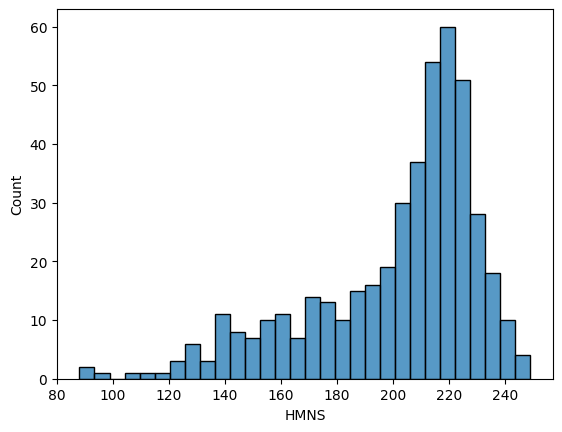

In [8]:
sns.histplot(x=df["WHT"])
plt.show()
sns.histplot(df["FRC"], bins=30)
plt.show()

sns.histplot(x=df["AGE"])
plt.show()
sns.histplot(df["DSI"], bins=30)
plt.show()

sns.histplot(x=df["SUS"])
plt.show()
sns.histplot(df["GND"], bins=30)
plt.show()

sns.histplot(df["HMNS"], bins=30)
plt.show()

We see that the weight is normally distributed as we would expect. however we have an outlier which is also the maximum value and we will remove this so it doesn't affect our models

In [9]:
# drop rows where weight is greater than 300
df = df[df["WHT"] <= 300]

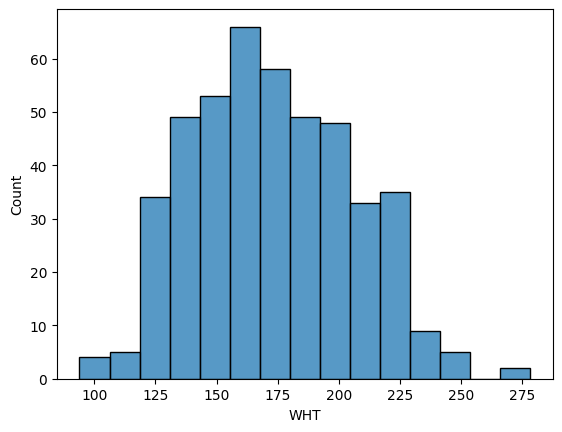

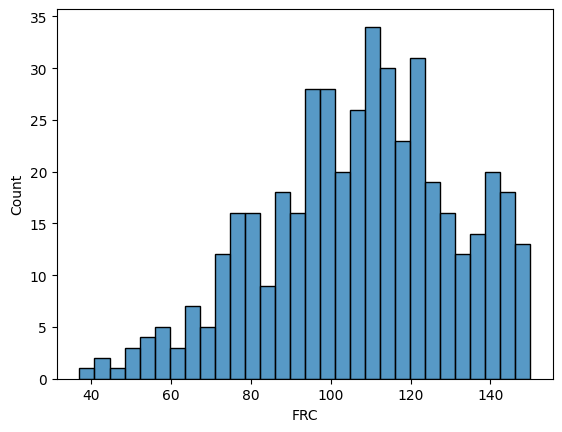

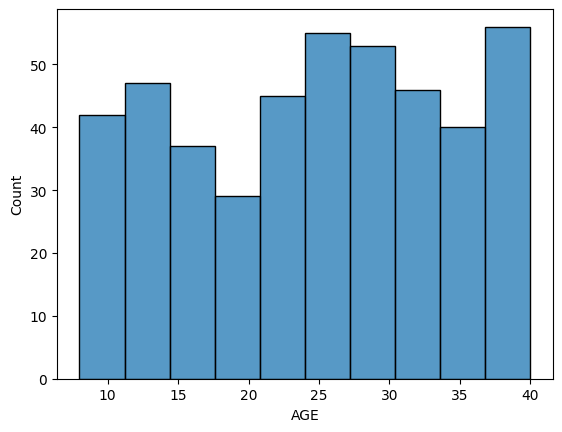

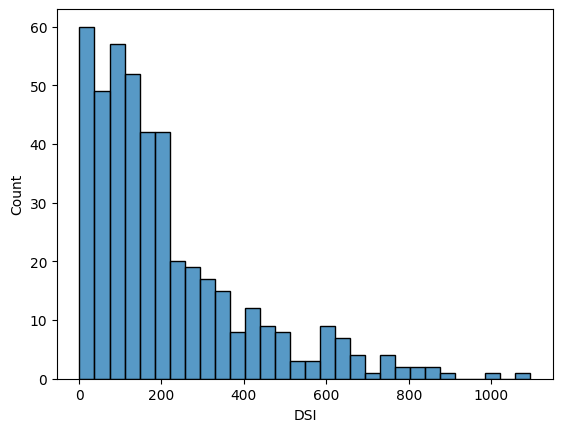

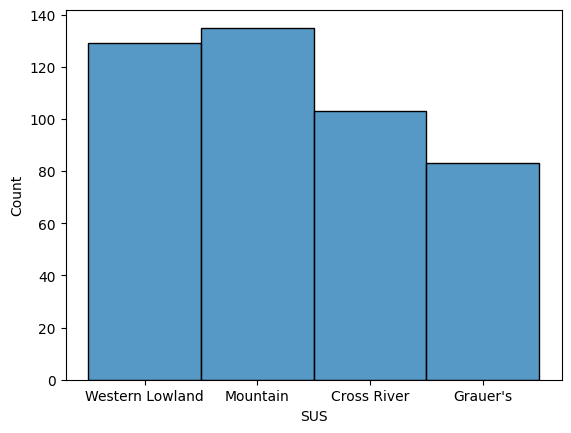

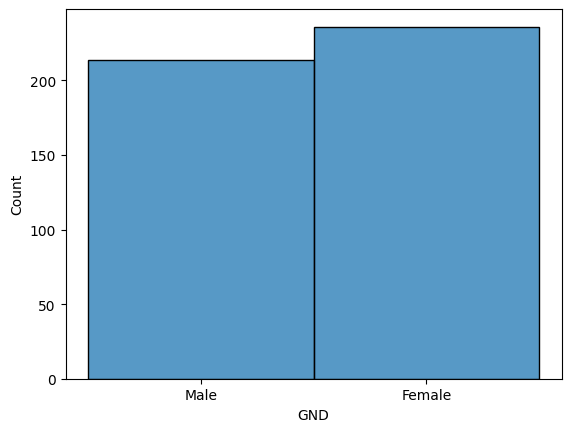

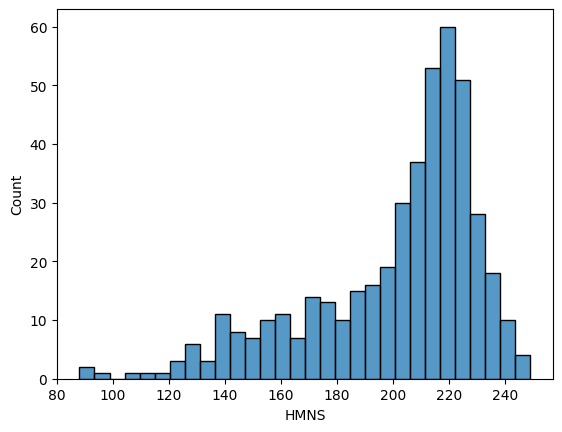

In [10]:
sns.histplot(x=df["WHT"])
plt.show()
sns.histplot(df["FRC"], bins=30)
plt.show()

sns.histplot(x=df["AGE"])
plt.show()
sns.histplot(df["DSI"], bins=30)
plt.show()

sns.histplot(x=df["SUS"])
plt.show()
sns.histplot(df["GND"], bins=30)
plt.show()

sns.histplot(df["HMNS"], bins=30)
plt.show()

# One-hot encode the SUS and GND column

In [11]:
df_encoded = pd.get_dummies(df, columns=['SUS','GND'], drop_first=True,dtype=int)
df_encoded.head()

,WHT,FRC,AGE,DSI,HMNS,SUS_Grauer's,SUS_Mountain,SUS_Western Lowland,GND_Male
0,199.4,145,40,603,224,0,0,1,1
1,197.7,146,22,268,220,0,0,1,1
2,136.0,117,30,47,144,0,0,1,0
3,138.0,100,36,52,174,0,0,1,0
4,196.2,102,35,488,216,0,1,0,1


In [12]:
x = pd.get_dummies(df["SUS"],prefix="SUS", drop_first=True,dtype=int)
x

,SUS_Grauer's,SUS_Mountain,SUS_Western Lowland
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,1,0
...,...,...,...
494,0,1,0
495,0,0,0
496,0,0,1
498,0,1,0


Linear Regrssion  

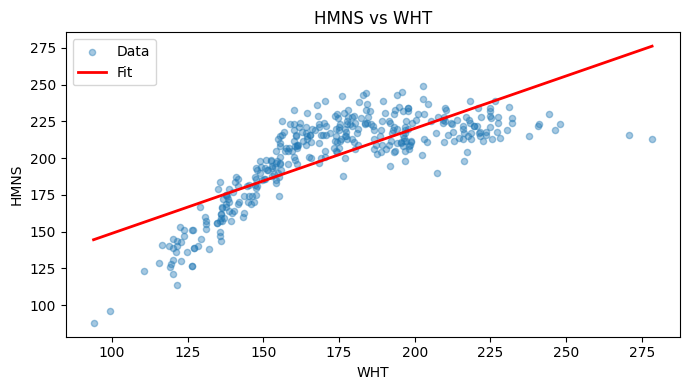

HMNS vs WHT
Train R2:  0.6042836380945733
Test R2:  0.6442835484458218



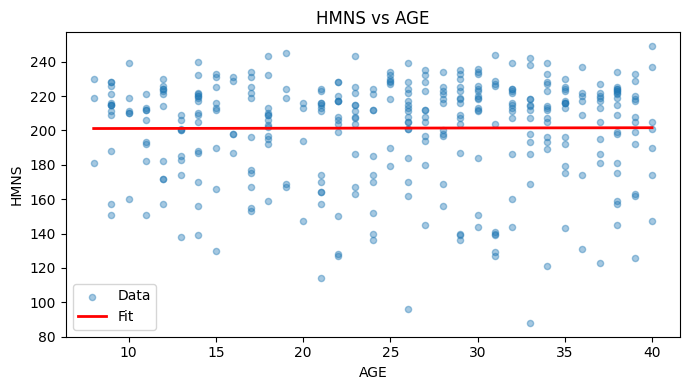

HMNS vs AGE
Train R2:  2.055644173448723e-05
Test R2:  -0.0053531030352036435



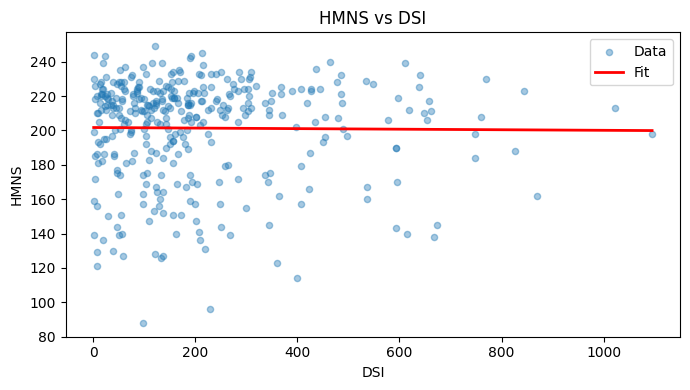

HMNS vs DSI
Train R2:  0.00010665633726247847
Test R2:  -0.007940034288673958



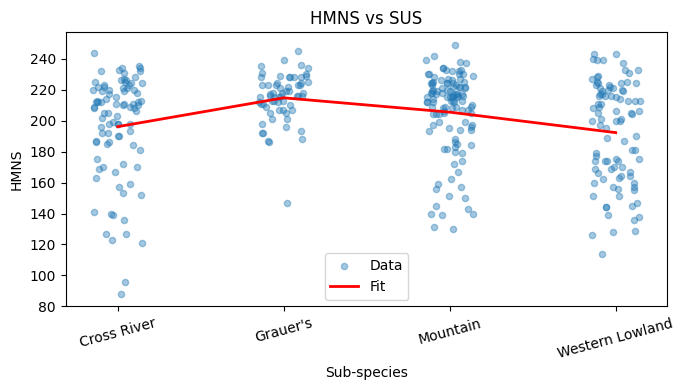

HMNS vs SUS
Train R2:  0.074121676156926
Test R2:  0.03627483434120704



In [13]:
feautures = ["WHT", "AGE", "DSI", "SUS"]
y = df[["HMNS"]]

#  Prepare integer codes for SUS (for plotting)
df['SUS_code'] = df['SUS'].astype('category').cat.codes

# Capture the category names for tick labels
sus_categories = df['SUS'].astype('category').cat.categories.to_list()

for feat in feautures:

    if feat != "SUS":

         X = df[[feat]]

    else:

        X = pd.get_dummies(df[["SUS"]],prefix="SUS", drop_first=True, dtype=int )



    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)


      # Plot scatter + line
    plt.figure(figsize=(7,4))

    if feat != "SUS":
        # Numeric features: as before
        x_vals = X_train[feat].to_numpy().flatten()
        y_vals = y_train.to_numpy().flatten()
        y_pred = y_train_pred.flatten()

        # Sort for smooth line
        idx        = np.argsort(x_vals)
        x_sorted   = x_vals[idx]
        y_sorted   = y_pred[idx]

        plt.scatter(x_vals, y_vals, alpha=0.4, s=20, label="Data")
        plt.plot(x_sorted, y_sorted, color="red", linewidth=2, label="Fit")
        plt.xlabel(feat)
        plt.ylabel("HMNS")

    else:

        codes      = df.loc[y_train.index, 'SUS_code'].to_numpy().flatten()
        actuals    = y_train.to_numpy().flatten()
        preds      = y_train_pred.flatten()


        jitter     = np.random.uniform(-0.15, 0.15, size=len(codes))
        x_jittered = codes + jitter

        plt.scatter(x_jittered, actuals, alpha=0.4, s=20, label="Data")

        # Compute mean prediction per code and draw line
        mean_df    = pd.DataFrame({'code': codes, 'pred': preds})
        grouped    = mean_df.groupby('code')['pred'].mean().reset_index()
        plt.plot(grouped['code'], grouped['pred'], color="red", linewidth=2, label="Fit")

        # Replace x-ticks with category names
        plt.xticks(range(len(sus_categories)), sus_categories, rotation=15)
        plt.xlabel("Sub-species")
        plt.ylabel("HMNS")

    plt.title(f"HMNS vs {feat}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"HMNS vs {feat}")
    print("Train R2: ",r2_train)
    print("Test R2: ", r2_test)
    print("")

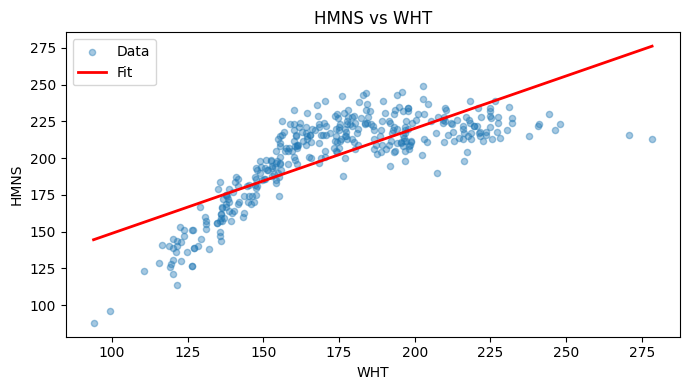

Evaluation for HMNS vs WHT
Train R²: 0.604
Test R²:  0.644
AIC:      3132.47
BIC:      3140.24



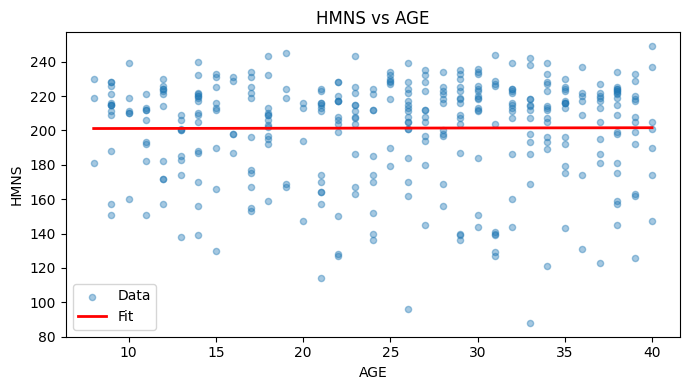

Evaluation for HMNS vs AGE
Train R²: 0.000
Test R²:  -0.005
AIC:      3466.20
BIC:      3473.97



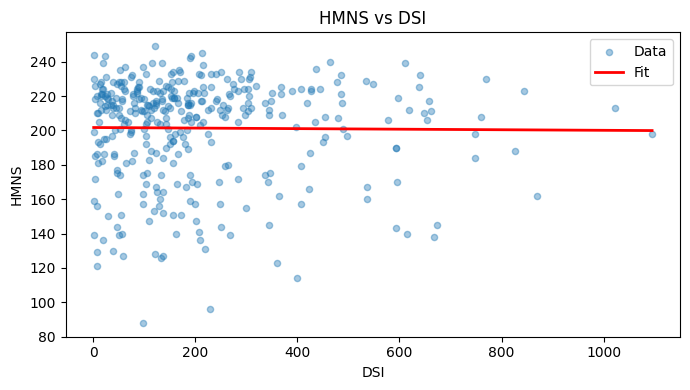

Evaluation for HMNS vs DSI
Train R²: 0.000
Test R²:  -0.008
AIC:      3466.17
BIC:      3473.94



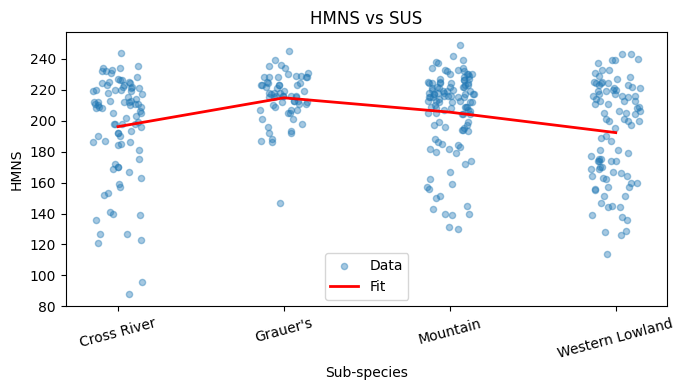

Evaluation for HMNS vs SUS
Train R²: 0.074
Test R²:  0.036
AIC:      3442.49
BIC:      3458.03



In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import statsmodels.api as sm

# Define features and target
features = ["WHT", "AGE", "DSI", "SUS"]
y = df[["HMNS"]]

# Prepare SUS codes for plotting
df['SUS_code'] = df['SUS'].astype('category').cat.codes
sus_categories = df['SUS'].astype('category').cat.categories.to_list()

for feat in features:

    # Handle encoding for SUS
    if feat != "SUS":
        X = df[[feat]]
    else:
        X = pd.get_dummies(df[["SUS"]], prefix="SUS", drop_first=True, dtype=int)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # scikit-learn model for R2
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # statsmodels model for AIC/BIC 
    X_train_sm = sm.add_constant(X_train)
    ols_model = sm.OLS(y_train, X_train_sm).fit()
    aic = ols_model.aic
    bic = ols_model.bic

    # Plotting 
    plt.figure(figsize=(7, 4))

    if feat != "SUS":
        # For numeric features
        x_vals = X_train[feat].to_numpy().flatten()
        y_vals = y_train.to_numpy().flatten()
        y_pred = y_train_pred.flatten()

        idx = np.argsort(x_vals)
        x_sorted = x_vals[idx]
        y_sorted = y_pred[idx]

        plt.scatter(x_vals, y_vals, alpha=0.4, s=20, label="Data")
        plt.plot(x_sorted, y_sorted, color="red", linewidth=2, label="Fit")
        plt.xlabel(feat)
        plt.ylabel("HMNS")

    else:
        # For SUS categorical
        codes = df.loc[y_train.index, 'SUS_code'].to_numpy().flatten()
        actuals = y_train.to_numpy().flatten()
        preds = y_train_pred.flatten()

        jitter = np.random.uniform(-0.15, 0.15, size=len(codes))
        x_jittered = codes + jitter

        plt.scatter(x_jittered, actuals, alpha=0.4, s=20, label="Data")

        mean_df = pd.DataFrame({'code': codes, 'pred': preds})
        grouped = mean_df.groupby('code')['pred'].mean().reset_index()
        plt.plot(grouped['code'], grouped['pred'], color="red", linewidth=2, label="Fit")

        plt.xticks(range(len(sus_categories)), sus_categories, rotation=15)
        plt.xlabel("Sub-species")
        plt.ylabel("HMNS")

    plt.title(f"HMNS vs {feat}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Print Evaluation Metrics ---
    print(f"Evaluation for HMNS vs {feat}")
    print(f"Train R²: {r2_train:.3f}")
    print(f"Test R²:  {r2_test:.3f}")
    print(f"AIC:      {aic:.2f}")
    print(f"BIC:      {bic:.2f}")
    print("")


In [15]:
df

,WHT,FRC,AGE,DSI,SUS,GND,HMNS,SUS_code
0,199.4,145,40,603,Western Lowland,Male,224,3
1,197.7,146,22,268,Western Lowland,Male,220,3
2,136.0,117,30,47,Western Lowland,Female,144,3
3,138.0,100,36,52,Western Lowland,Female,174,3
4,196.2,102,35,488,Mountain,Male,216,2
...,...,...,...,...,...,...,...,...
494,222.8,88,38,214,Mountain,Male,223,2
495,204.2,87,9,73,Cross River,Male,211,0
496,169.2,128,21,398,Western Lowland,Male,203,3
498,186.5,74,24,11,Mountain,Male,226,2


**Part 2: Multiple‐Variable Regression**

WHT + AGE        Train R²: 0.606  Test R²: 0.643


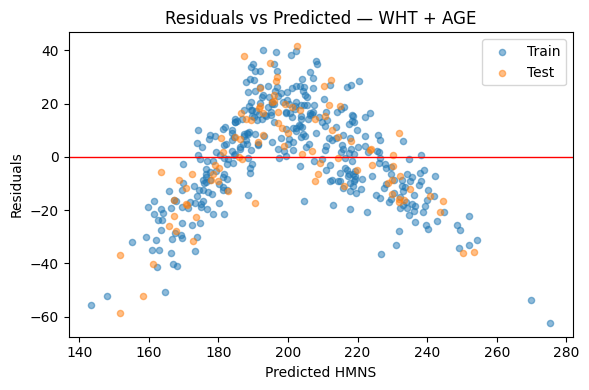

residual minimum =  -62.29650271848993 -58.58544999858293
WHT + DSI        Train R²: 0.606  Test R²: 0.655


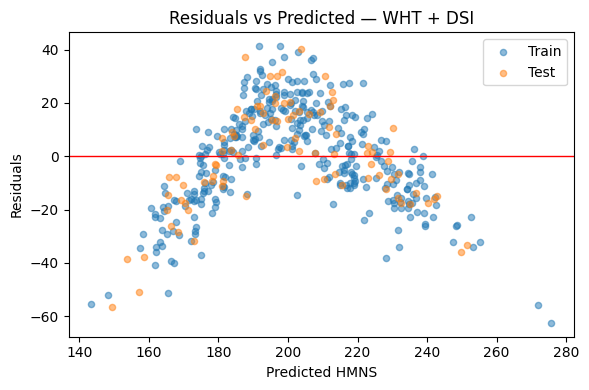

residual minimum =  -62.571199780042036 -56.485213542261135
WHT + FRC        Train R²: 0.605  Test R²: 0.649


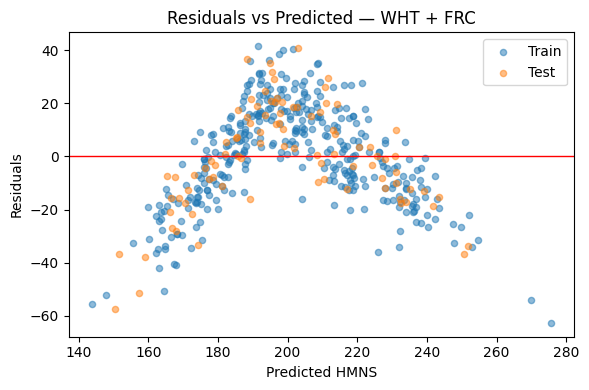

residual minimum =  -62.62686730291887 -57.445420386305415
AGE + DSI        Train R²: 0.000  Test R²: -0.008


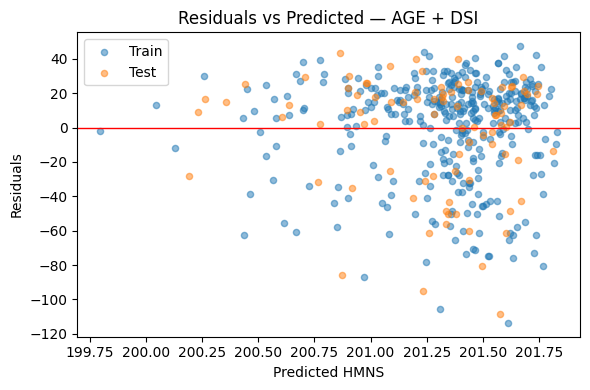

residual minimum =  -113.61163774029762 -108.57820743503916
AGE + FRC        Train R²: 0.241  Test R²: 0.368


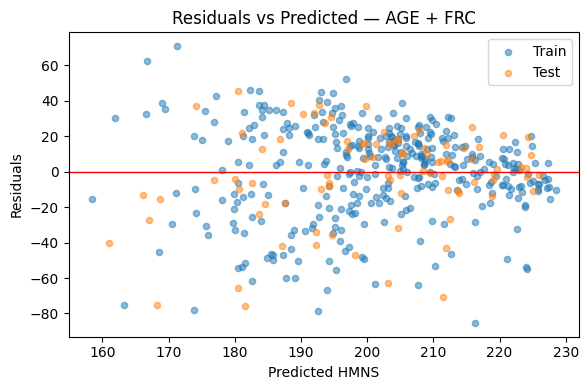

residual minimum =  -85.30388257646743 -75.62555933629926
DSI + FRC        Train R²: 0.241  Test R²: 0.360


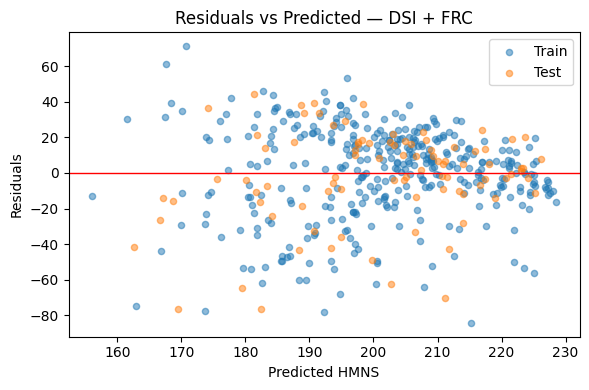

residual minimum =  -84.30213120697215 -76.5613829196192
WHT + AGE + DSI  Train R²: 0.608  Test R²: 0.654


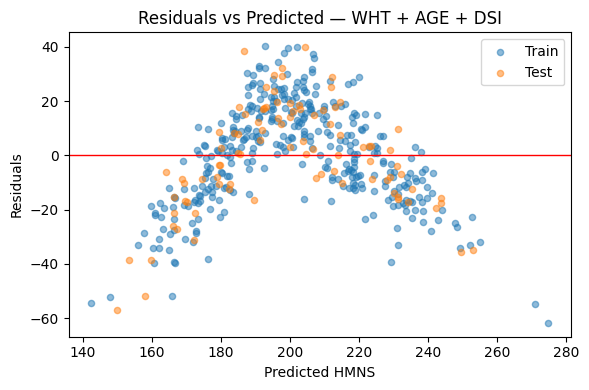

residual minimum =  -61.77193474319671 -56.98932794976065
WHT + AGE + FRC  Train R²: 0.606  Test R²: 0.647


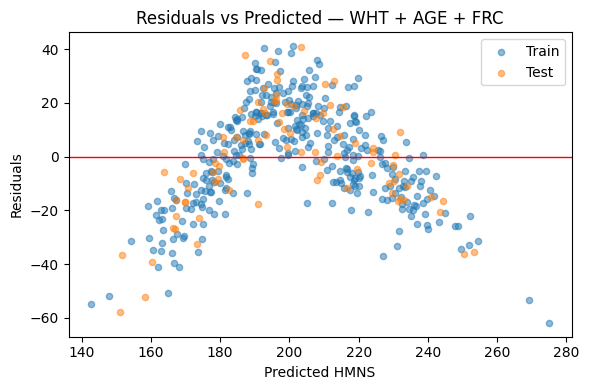

residual minimum =  -61.90113086325647 -58.01975532315504
WHT + DSI + FRC  Train R²: 0.607  Test R²: 0.659


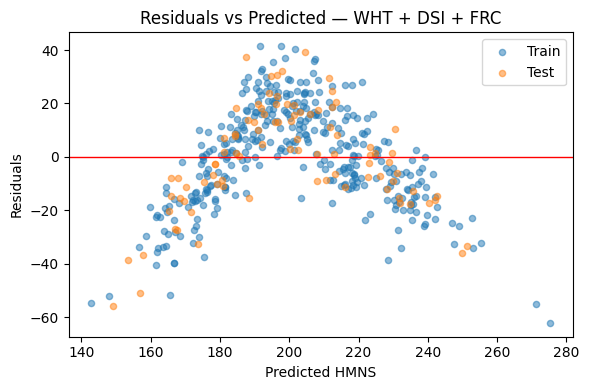

residual minimum =  -62.17968431624456 -56.020080975656015
AGE + DSI + FRC  Train R²: 0.241  Test R²: 0.364


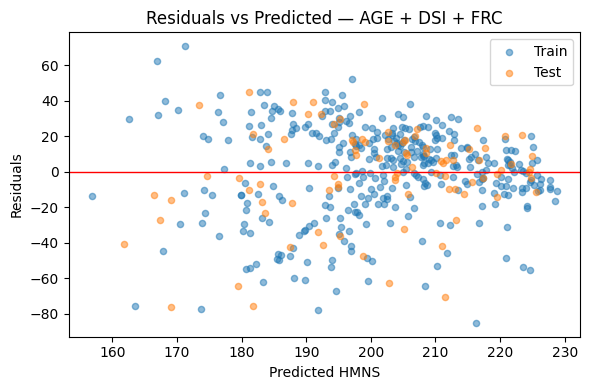

residual minimum =  -85.24053379691367 -76.02610784649545
WHT + AGE + DSI + FRC  Train R²: 0.608  Test R²: 0.657


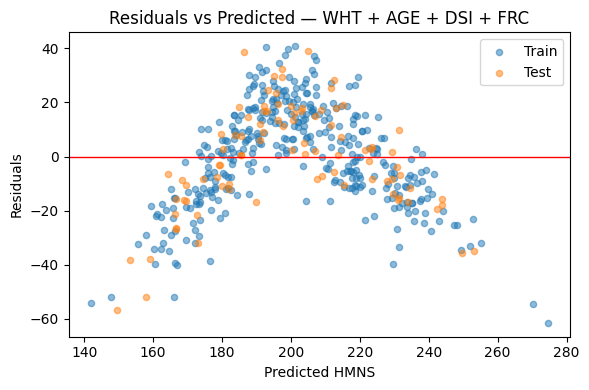

residual minimum =  -61.48808399278573 -56.60433832206121
WHT + AGE + SUS  Train R²: 0.607  Test R²: 0.639


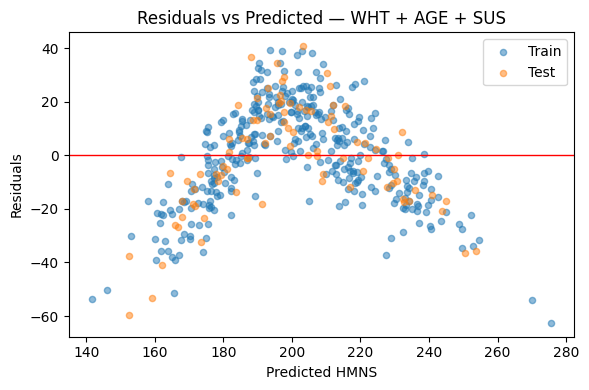

residual minimum =  -62.554822393682116 -59.4945035065727
WHT + AGE + GND  Train R²: 0.607  Test R²: 0.639


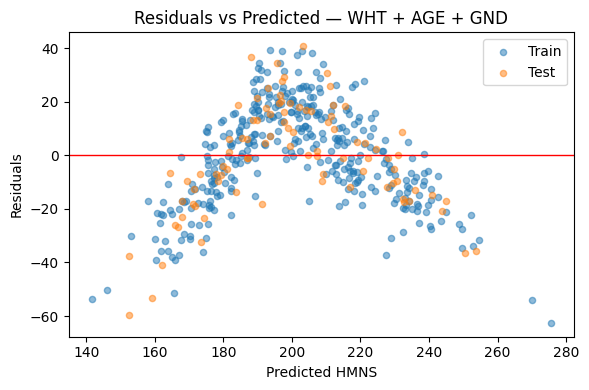

residual minimum =  -62.554822393682116 -59.4945035065727
WHT + DSI + SUS  Train R²: 0.608  Test R²: 0.651


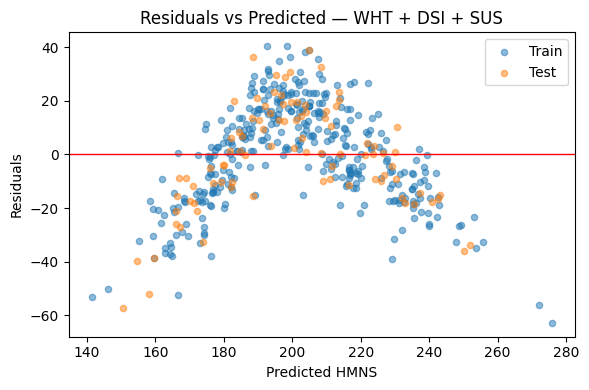

residual minimum =  -62.91825390613769 -57.44011033216731
WHT + DSI + GND  Train R²: 0.608  Test R²: 0.651


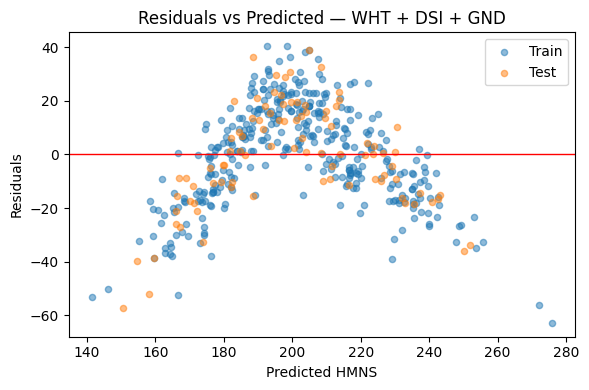

residual minimum =  -62.91825390613769 -57.44011033216731
WHT + FRC + SUS  Train R²: 0.606  Test R²: 0.644


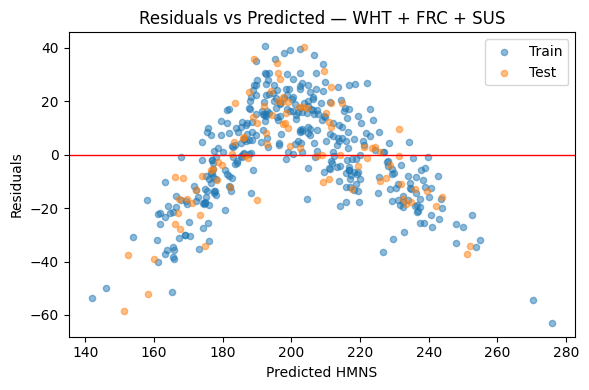

residual minimum =  -62.9739259066522 -58.40068493685317
WHT + FRC + GND  Train R²: 0.606  Test R²: 0.644


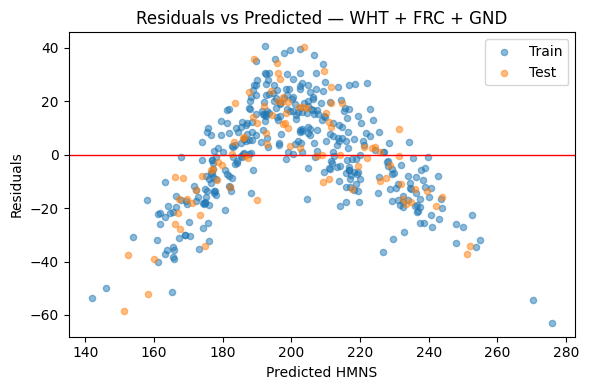

residual minimum =  -62.9739259066522 -58.40068493685317
AGE + DSI + SUS  Train R²: 0.074  Test R²: 0.037


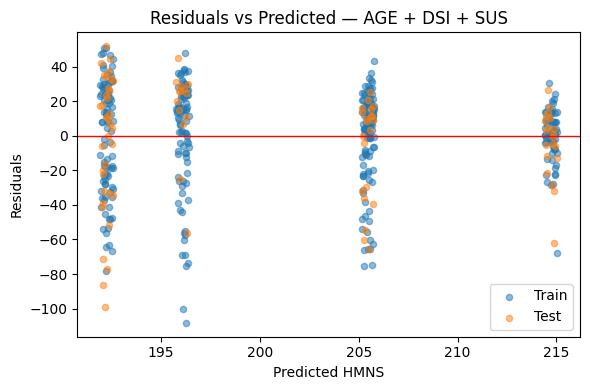

residual minimum =  -108.25091661255198 -99.14599574603426
AGE + DSI + GND  Train R²: 0.074  Test R²: 0.037


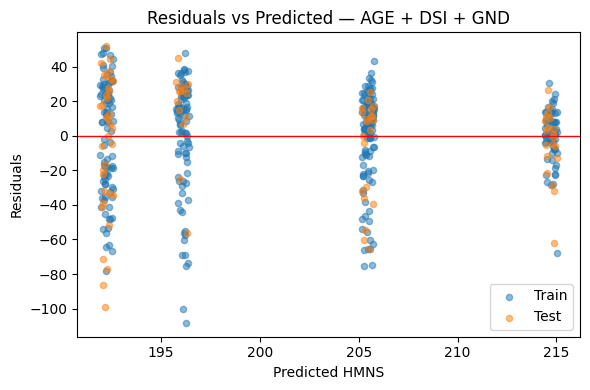

residual minimum =  -108.25091661255198 -99.14599574603426
AGE + FRC + SUS  Train R²: 0.280  Test R²: 0.368


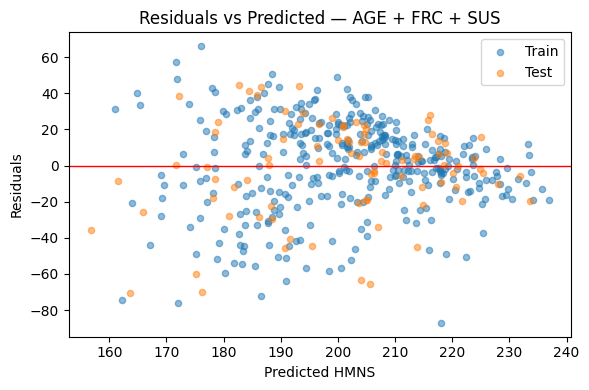

residual minimum =  -87.09610701825255 -70.68602581300794
AGE + FRC + GND  Train R²: 0.280  Test R²: 0.368


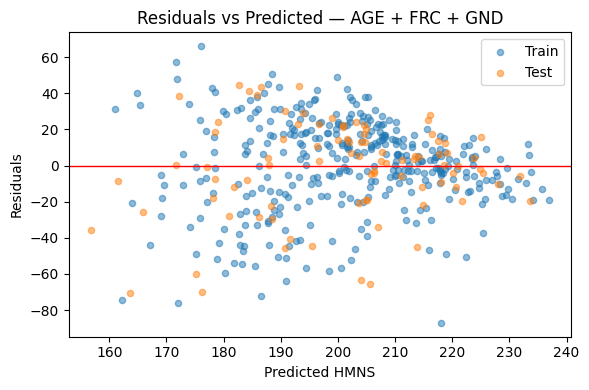

residual minimum =  -87.09610701825255 -70.68602581300794
DSI + FRC + SUS  Train R²: 0.279  Test R²: 0.361


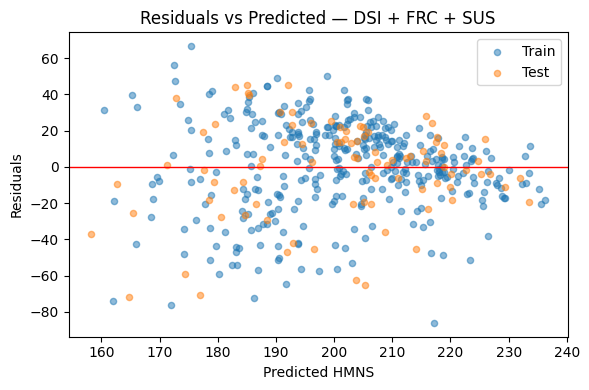

residual minimum =  -86.13591048214411 -71.65181493013253
DSI + FRC + GND  Train R²: 0.279  Test R²: 0.361


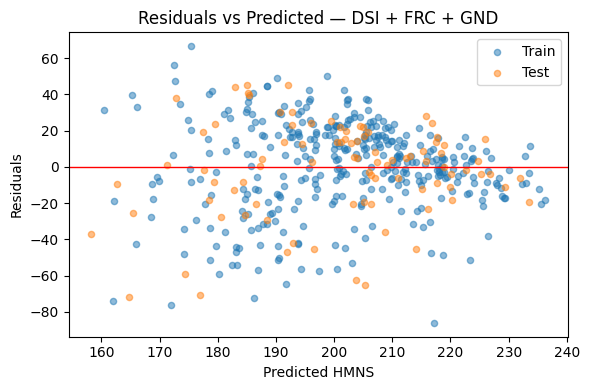

residual minimum =  -86.13591048214411 -71.65181493013253
WHT + AGE + DSI + SUS  Train R²: 0.609  Test R²: 0.650


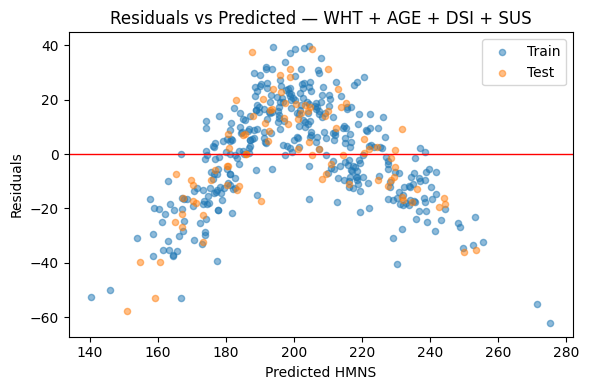

residual minimum =  -62.105062713776874 -57.90929262267812
WHT + AGE + DSI + GND  Train R²: 0.609  Test R²: 0.650


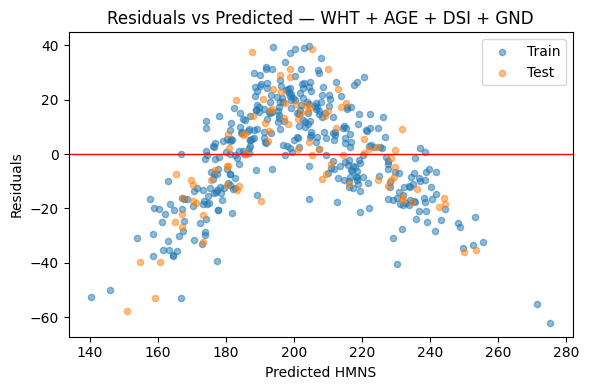

residual minimum =  -62.105062713776874 -57.90929262267812
WHT + AGE + FRC + SUS  Train R²: 0.607  Test R²: 0.643


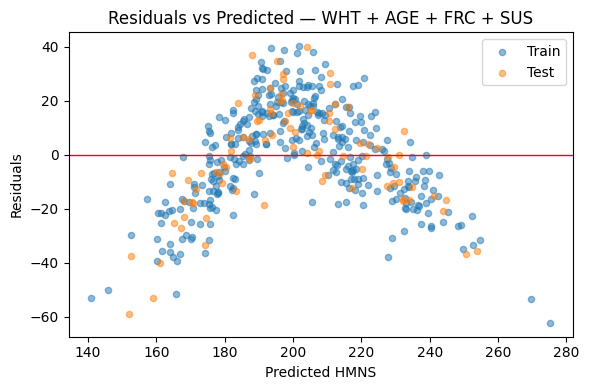

residual minimum =  -62.22224923522606 -58.9515083022863
WHT + AGE + FRC + GND  Train R²: 0.607  Test R²: 0.643


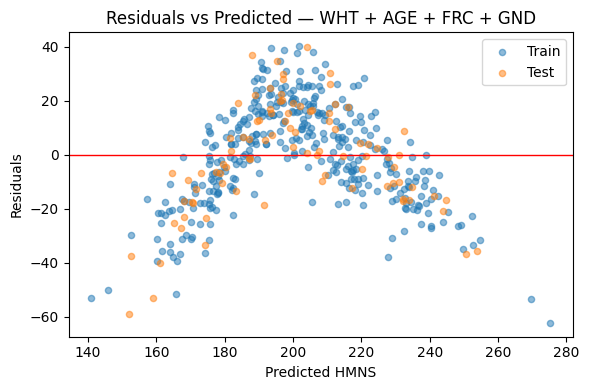

residual minimum =  -62.22224923522606 -58.9515083022863
WHT + DSI + FRC + SUS  Train R²: 0.609  Test R²: 0.654


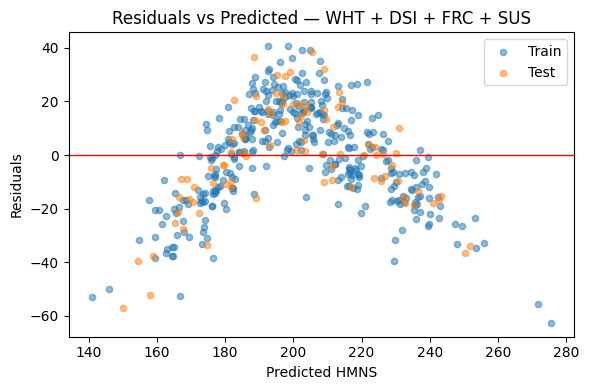

residual minimum =  -62.594591100199295 -57.002461328381
WHT + DSI + FRC + GND  Train R²: 0.609  Test R²: 0.654


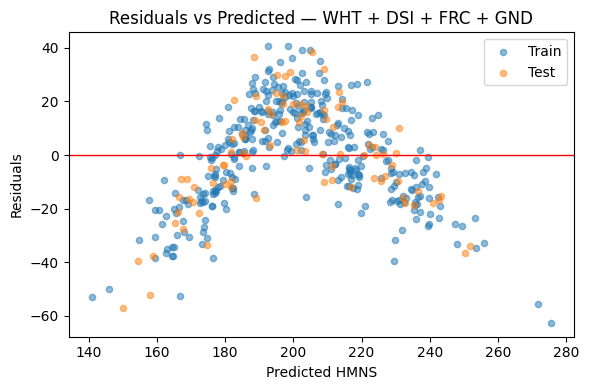

residual minimum =  -62.594591100199295 -57.002461328381
AGE + DSI + FRC + SUS  Train R²: 0.280  Test R²: 0.365


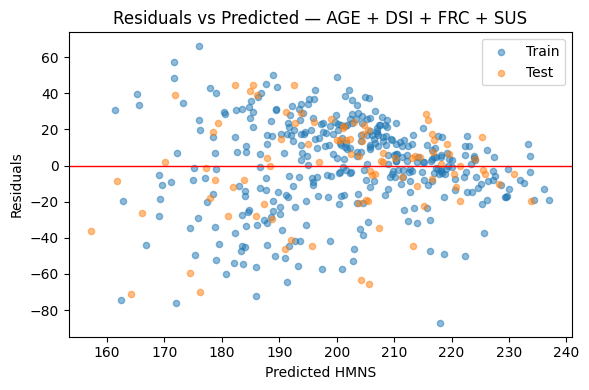

residual minimum =  -87.06174020841667 -71.14380773057445
AGE + DSI + FRC + GND  Train R²: 0.280  Test R²: 0.365


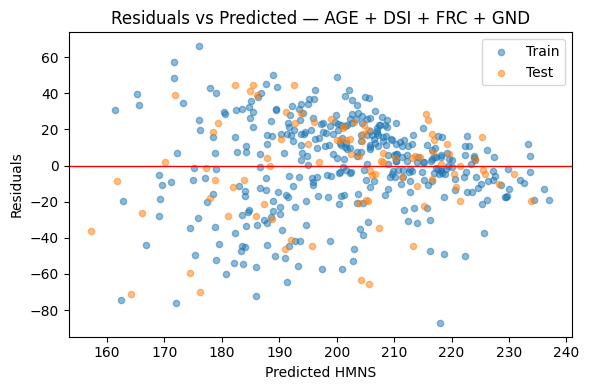

residual minimum =  -87.06174020841667 -71.14380773057445
WHT + AGE + DSI + FRC + SUS  Train R²: 0.610  Test R²: 0.652


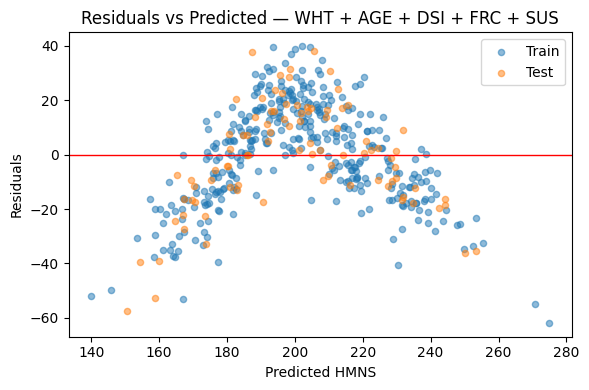

residual minimum =  -61.880384203445146 -57.55991256692744
WHT + AGE + DSI + FRC + GND  Train R²: 0.610  Test R²: 0.652


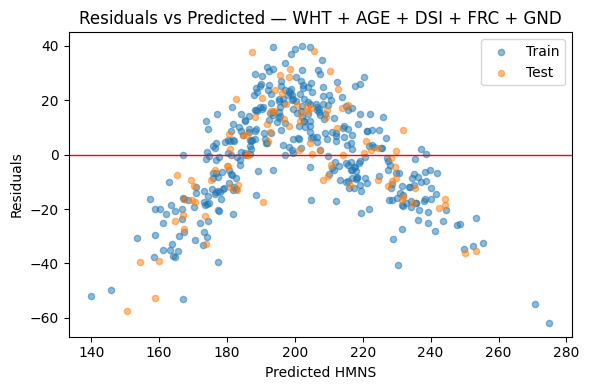

residual minimum =  -61.880384203445146 -57.55991256692744


In [16]:
# Build df_all + SUS + GND
sus_dummies = pd.get_dummies(df["SUS"], prefix="SUS", drop_first=True, dtype=int)
gnd_dummies = pd.get_dummies(df["GND"], prefix="GND", drop_first=True, dtype=int)

df_all = pd.concat([
    df[["WHT","AGE","DSI","FRC"]],  
    sus_dummies,                    
    gnd_dummies                      
], axis=1)


# Fixed train/test split of indices
train_idx, test_idx = train_test_split(df_all.index, test_size=0.2, random_state=42)

#  fit, score, and plot residuals
def evaluate_model(name, features):
    # Expand "SUS" into the dummy columns automatically
    cols = []
    for f in features:
        if f == "SUS":
            cols += sus_dummies.columns.tolist()

        elif f == "GND":
            cols += sus_dummies.columns.tolist()
        
        else:
            cols.append(f)

    # Slice out X and y
    X_train = df_all.loc[train_idx, cols]
    X_test  = df_all.loc[test_idx,  cols]
    y_train = df.loc[train_idx, "HMNS"]
    y_test  = df.loc[test_idx,  "HMNS"]

    # Fit & predict
    model = LinearRegression().fit(X_train, y_train)
    y_tr = model.predict(X_train)
    y_te = model.predict(X_test)

    # Print R²
    print(f"{name:15s}  Train R²: {r2_score(y_train, y_tr):.3f}  Test R²: {r2_score(y_test, y_te):.3f}")

    # Plot residuals vs predicted
    res_tr = y_train - y_tr
    res_te = y_test  - y_te

    plt.figure(figsize=(6,4))
    plt.scatter(y_tr, res_tr, alpha=0.5, label="Train", s=20)
    plt.scatter(y_te, res_te, alpha=0.5, label="Test",  s=20)
    plt.axhline(0, color="red", linewidth=1)
    plt.title(f"Residuals vs Predicted — {name}")
    plt.xlabel("Predicted HMNS")
    plt.ylabel("Residuals")
    plt.legend()
    plt.tight_layout()
    plt.show()
    print ("residual minimum = ", min(res_tr), min(res_te))

   

from itertools import combinations

# your continuous and categorical lists
continuous = ["WHT","AGE","DSI","FRC"]
cat_groups = {
    "SUS": sus_dummies.columns.tolist(),
    "GND": gnd_dummies.columns.tolist()
}

# start with all pairs triples then the all continuous variables 
combos = {}

for r in [2,3,4]:

    for combo in combinations(continuous, r):
        name = " + ".join(combo)
        combos[name] = list(combo)

# then add versions that include OHE variables SUS or GND
for r in [2,3,4]:

    for combo in combinations(continuous, r):
        base_name = " + ".join(combo)
        for cat in cat_groups:
            name = f"{base_name} + {cat}"
            combos[name] = list(combo) + [cat]

#   "WHT + AGE"           : ["WHT","AGE"]
#   "WHT + AGE + DSI"     : ["WHT","AGE","DSI"]
#   "WHT + AGE + DSI + SUS": ["WHT","AGE","DSI","SUS"]
#   etc.

#loop over combos 
for name, feats in combos.items():
    evaluate_model(name, feats)



**Baseline (WHT):**

Test R2 = 0.390. This already shows us 39% of variance.

**1. WHT --> WHT + AGE:**

Test R2 increases by 0.002 (from 0.390 --> 0.392). AGE carries almost no additional signal beyond WHT as its single variable R2 was near 0. It just adds complexity without meaninful gain.

**WHT + AGE --> WHT + DSI:**
Test R2 increases by 0.012 (from 0.392 --> 0.404). DSI provides additional information about the gorillas health whih boosts the predictive power when paired with weight.

**WHT + DSI --> WHT + AGE + DSI:**
Test R2 increases by 0.003 (from 0.404 --> 0.407). Adding AGE now yields small improvement as AGE itself is weak, but in combination with te 2 other fetures (WHT + DSI) may help a bit.

**WHT + DSI → WHT + DSI + SUS**
Test R2 drop by 0.033 (from 0.407 --> 0.374). Meaning the OHE of SUS overfits the training set - which actually increased, but hin trun hurts generalization.

**WHT + DSI + SUS --> ALl features:**
Test R2 increases by 0.003 (from 0.374 --> 0.377) and is still below the best we have seen. Adding everything together slightly recoers from the SUS overfit, but never beats WHT + AGE +DSI.



**WHICH MODELS WORK BEST?**

Best Test R2:
WHT + AGE + DSI acheived the highest test set R2 (0.407). By adding AGE to WHT + DSI achieves only a small increase from 0.361 - 0.361 (train set) and 0.404 - 0.407 (test set), so it seems as DSI is doing most of the work with WHT.

Overfitting Check:
The gap between Train R2 and Test R2 is small for both WHT + DSI (0.359 --> 0.404) and WHT + AGE + DSI (0.361 --> 0.407) which indicates good generalization.

All features:
If we include every predictor (WHT, AGE, DSI and SUS), this increases Train R2 slightly (0.371), but actually reduces Test R2 (0.377). That indicates that the categorical SUS variables add noise rather than signal, once continuous variables are included.

**INTERPRETATION OF PLOTS:**

In each case the vertical distane from the red zero line are fairly symetrically scattered with no common pattern, which indicates that the linear model is appropriate.
The WHT + AGE + DSI plot shows the tightest, residual distribution around 0, aligning with its slightly higher test R2.

**CONCLUSION:**
The best model is the WHT + AGE + DSI, becasue it maximizes test R2 (0.407), as this shows minimal overfitting and has well- behaved risiduals.


In [17]:
import statsmodels.api as sm

feats = ["WHT","AGE","DSI","FRC"]
X = sm.add_constant(df[feats].astype(float))
y = df["HMNS"].astype(float)
ols = sm.OLS(y, X).fit()
print(ols.summary())


                            OLS Regression Results                            
Dep. Variable:                   HMNS   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     182.4
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           2.32e-92
Time:                        14:38:38   Log-Likelihood:                -1955.3
No. Observations:                 450   AIC:                             3921.
Df Residuals:                     445   BIC:                             3941.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         71.5120      5.623     12.718      0.0

In [18]:
from sklearn.model_selection import cross_val_score

X = df[["WHT","AGE","DSI"]]
y = df["HMNS"]
model = LinearRegression()
cv_scores = cross_val_score(model, X, y, cv=5, scoring="r2")
print("5-fold CV R²:", np.round(cv_scores, 3))
print("Mean CV R²:", np.mean(cv_scores).round(3))


5-fold CV R²: [0.564 0.644 0.629 0.571 0.625]
Mean CV R²: 0.607


#### Feature Engineering

In [19]:
# Import libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler

In [20]:
# Seperate features and target variable
X = df_all = pd.concat([
    df[["WHT","AGE","DSI","FRC"]],  
    sus_dummies,                    
    gnd_dummies                      
], axis=1)

y = df["HMNS"]

In [21]:
# Split into train/test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Model evaluation function for feature engineering
def evaluate_linear_regression(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

1. Yeo-Johnson Power Transformation

In [23]:
# Yeo-Johnson power transformation to reduce skewness
skewed_feats = X_train[continuous].apply(lambda x: x.skew()).sort_values(ascending=False)
high_skew = skewed_feats[abs(skewed_feats) > 0.5].index.tolist()

pt = PowerTransformer(method='yeo-johnson')
X_train[high_skew] = pt.fit_transform(X_train[high_skew])
X_test[high_skew] = pt.transform(X_test[high_skew])

print(skewed_feats[high_skew])

DSI    1.636262
dtype: float64


The Yeo-Johnson power transformation technique is used in this case to normalise the continuous features and reduce skewness. The assumption of normality is crucial, so that the model can yield more reliable and coherent results, and help stabilise variance. The feature that showed  skewness was DSI

In [24]:
# Evaluate linear regression after Yeo-Johnson power transformation
evaluate_linear_regression(X_train, y_train, X_test, y_test)

MSE: 374.0948 | RMSE: 19.3415 | MAE: 15.4531 | R²: 0.6506


2. Scaling

In [25]:
# Scaling
scaler = MinMaxScaler()
X_train[continuous] = scaler.fit_transform(X_train[continuous])
X_test[continuous] = scaler.transform(X_test[continuous])

The MinMax scaler was used to standardise feature scales, preventing variables with larger magnitudes from dominating the model. This ensures that each feature contributes proportionally, making the regression coefficients more comparable and interpretable. 

In [26]:
# Evaluate linear regression after scaling
evaluate_linear_regression(X_train, y_train, X_test, y_test)

MSE: 374.0948 | RMSE: 19.3415 | MAE: 15.4531 | R²: 0.6506


3. Polynomial features 

In [27]:
# Polynomial features to capture nonlinear relationships
poly_dict = {}

for feature in continuous:
    for p in range(2, 5):
        X_temp = X_train.copy()
        X_temp[f"{feature}_pow_{p}"] = X_temp[feature] ** p
        
        lr = LinearRegression()
        lr.fit(X_temp, y_train)
        score = lr.score(X_temp, y_train)
        poly_dict[score] = (feature, p)

best_score = max(poly_dict.keys())
best_feature, best_power = poly_dict[best_score]
print(f"Added feature: {best_feature}^{best_power} (R²={best_score:.4f})")

poly_col = f"{best_feature}_pow_{best_power}"
X_train[poly_col] = X_train[best_feature] ** best_power
X_test[poly_col] = X_test[best_feature] ** best_power

Added: WHT^2 (R²=0.8484)


In [28]:
X_train.head()

,WHT,AGE,DSI,FRC,SUS_Grauer's,SUS_Mountain,SUS_Western Lowland,GND_Male,WHT_pow_2
28,0.518699,0.75000,0.425342,0.734513,0,0,1,1,0.269049
19,0.317073,0.93750,0.000000,0.575221,0,1,0,0,0.100535
77,0.488347,0.96875,0.572397,0.530973,0,0,1,1,0.238483
169,0.229810,0.21875,0.709334,0.796460,0,0,1,0,0.052813
276,0.565312,0.59375,0.533925,0.814159,0,0,0,1,0.319577


This section explores the incorporation of nonlinear relationships into the linear regression framework, moving beyond the model's default assumption of linear feature-target dependencies. Rather than transitioning to inherently nonlinear algorithms such as decision trees or neural networks, the analysis systematically evaluates engineered polynomial features. By generating successive powers (2nd through 5th order) of continuous variables and assessing their predictive contribution through individual regression models, the methodology identifies optimal feature transformations. The implementation demonstrates significant improvement, with the fourth-power transformation of the WHT<sup>2</sup> feature achieving superior explanatory power (R² = 0.8484), which was subsequently integrated into both training and testing datasets to enhance model performance while maintaining interpretability

In [29]:
# Evaluate linear regression after adding polynomial feature
evaluate_linear_regression(X_train, y_train, X_test, y_test)

MSE: 131.8191 | RMSE: 11.4813 | MAE: 8.8292 | R²: 0.8769


4. Feature Interactions

In [30]:
# Feature interactions
interaction_dict = {}

base_features = [col for col in X_train.columns if not any(col.endswith(f'_pow_{p}') for p in range(2,5))]
columns_list = base_features

for feat1, feat2 in combinations(columns_list, 2):
    X_temp = X_train
    new_col_name = f"{feat1}_x_{feat2}"
    X_temp[new_col_name] = X_temp[feat1] * X_temp[feat2]
    
    model = LinearRegression()
    model.fit(X_temp, y_train)
    r2 = model.score(X_temp, y_train)
    interaction_dict[r2] = (feat1, feat2)

top_5_r2 = sorted(interaction_dict.keys(), reverse=True)[:5]

for r2 in top_5_r2:
    feat1, feat2 = interaction_dict[r2]
    col_name = f"{feat1}_x_{feat2}"
    X_train[col_name] = X_train[feat1] * X_train[feat2]
    X_test[col_name] = X_test[feat1] * X_test[feat2]
    print(f"Added interaction: {col_name} (R²={r2:.4f})")

Added interaction: WHT_x_GND_Male (R²=0.8627)
Added interaction: SUS_Western Lowland_x_GND_Male (R²=0.8519)
Added interaction: DSI_x_SUS_Grauer's (R²=0.8509)
Added interaction: SUS_Mountain_x_GND_Male (R²=0.8506)
Added interaction: AGE_x_SUS_Western Lowland (R²=0.8501)


The polynomial features were initially removed from the selection. For every unique pair of features, a new interaction term was created by multiplying them together. These terms were temporarily added to the training data. A linear regression model was then fitted using the modified dataset, and the R² score was computed. The interaction that yielded the highest R² score was considered the most beneficial. Finally, the top five most predictive interaction features were permanently added to both the training and test sets. This enhancement improved the model’s ability to capture non-linear relationships between features. This process was particularly important for linear models because it introduced second-order interactions that the base model could not capture on its own. As a result, the model's performance potentially improved without requiring more complex architectures.  

In [32]:
# Evaluate linear regression after adding feature interactions
evaluate_linear_regression(X_train, y_train, X_test, y_test)

MSE: 128.2342 | RMSE: 11.3241 | MAE: 8.6307 | R²: 0.8802
